Name: André Moreira Souza
NUSP: 9778985
Course Code: SCC0251
Semester: 2019/1
Assignment: 3 - Image Restoration
-

In [2]:
import numpy as np
import scipy
import imageio
import scipy
import scipy.fftpack

 ## Defining functions

In [3]:
# F == 1
def adaptive_denoising(g, gamma, k, mode):
	img_final = np.zeros(g.shape, dtype=np.double)
	
	# copying image borders from observed image
	img_final[:k//2, :] = g[:k//2, :]
	img_final[-(k//2):, :] = g[-(k//2):, :]
	img_final[:, :k//2] = g[:, :k//2]
	img_final[:, -(k//2):] = g[:, -(k//2):]
	
	# filtering for each mode

	# 'average' mode
	if mode == 'average':
		# calculating estimated dispersion measure
		disp_h = np.std(g[:g.shape[0]//6, :g.shape[1]//6])
		disp_h = 1 if disp_h == 0 else disp_h
		# applying denoising over each pixel
		for i in range(k//2, g.shape[0] - k//2):
			for j in range(k//2, g.shape[1] - k//2):
				# calculating centrality measure and dispersion measure over kxk neighborhood
				nh = g[i-k//2 : i+k//2 + 1, j-k//2 : j+k//2 + 1] # neighborhood
				centr_l = np.mean(nh)
				disp_l = np.std(nh)
				disp_l = disp_h if disp_l == 0 else disp_l
				# calculating result image pixels
				img_final[i][j] = g[i][j] - gamma * (disp_h / disp_l) * (g[i][j] - centr_l)

	# 'robust' mode
	elif mode == 'robust':
		# calculating estimated dispersion measure
		percents_h = np.percentile(g[:g.shape[0]//6, :g.shape[1]//6], [25, 75])
		disp_h = percents_h[1] - percents_h[0]
		disp_h = 1 if disp_h == 0 else disp_h
		# applying denoising over each pixel
		for i in range(k//2, g.shape[0] - k//2):
			for j in range(k//2, g.shape[1] - k//2):
				# calculating centrality measure and dispersion measure over kxk neighborhood
				nh = g[i-k//2 : i+k//2 + 1, j-k//2 : j+k//2 + 1] # neighborhood
				percents_l = np.percentile(nh, [25, 50, 75])
				centr_l = percents_l[1]
				disp_l = percents_l[2] - percents_l[0]
				disp_l = disp_h if disp_l == 0 else disp_l
				# calculating result image pixels
				img_final[i][j] = g[i][j] - gamma * (disp_h / disp_l) * (g[i][j] - centr_l)

	# error case: invalid input
	else: raise ValueError("Unexpected value for mode (should be in ['average', 'robust'])")
	# returning normalized image
	return normalize(img_final, g.max())
	

# F == 2
def constrained_least_squares(g, gamma, k, sigma):
	# img_final = np.zeros(g.shape, dtype=np.double)
	# Manually padding arrays of invalid shape
	p = np.zeros(g.shape, dtype=np.double)
	h = np.zeros(g.shape, dtype=np.double)
	lower_p_0 = (g.shape[0] // 2) - (3 // 2)
	upper_p_0 = (g.shape[0] // 2) + (3 // 2) + 1
	lower_p_1 = (g.shape[1] // 2) - (3 // 2)
	upper_p_1 = (g.shape[1] // 2) + (3 // 2) + 1
	p[lower_p_0 : upper_p_0, lower_p_1 : upper_p_1] = \
		np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], dtype=np.double) # laplacian operator
	lower_h_0 = (g.shape[0] // 2) - (k // 2)
	upper_h_0 = (g.shape[0] // 2) + (k // 2) + 1
	lower_h_1 = (g.shape[1] // 2) - (k // 2)
	upper_h_1 = (g.shape[1] // 2) + (k // 2) + 1
	h[lower_h_0 : upper_h_0, lower_h_1 : upper_h_1] = gaussian_filter(k, sigma) # gaussian filter

	# calculating 2d-fft of arrays
	G = scipy.fftpack.fft2(g)
	P = scipy.fftpack.fft2(p)
	H = scipy.fftpack.fft2(h)
	H_conj = np.conj(H)

	# calculating final image
	img_final = np.multiply((H_conj / (np.square(np.absolute(H)) + gamma * np.square(np.absolute(P)))), G)
	# getting real part of inverse fft
	img_final = np.real(scipy.fftpack.ifft2(img_final))
    
	# roll image for correct final representation (frequencies on the corners)
	return np.roll(img_final, np.array(g.shape)//2, (0, 1))

# gaussian_filter function
def gaussian_filter(k=3, sigma=1.0):
	arx = np.arange((-k // 2) + 1.0, (k // 2) + 1.0)
	x, y = np.meshgrid(arx, arx)
	filt = np.exp(-(1/2) * (np.square(x) + np.square(y)) / np.square(sigma))
	return filt / np.sum(filt)

# Normalize value of an numpy array between 0 and a given max value
def normalize (arr, maxvalue):
	return (arr-arr.min()) * (maxvalue / (arr.max()-arr.min()))

# root mean squared error (RMSE) function
def rmse (img_g, img_r):
	return np.sqrt(np.sum(np.power(img_g.astype(np.double) - img_r.astype(np.double), 2))/(img_g.shape[0]*img_g.shape[1]))

 ## Main function

In [5]:
if __name__ == '__main__':
	# get user input
	fpath, gpath = str(input()).strip(), str(input()).strip() # f = reference image, g = degraded image
	f, g = imageio.imread(fpath).astype(np.double), imageio.imread(gpath).astype(np.double) # reading images f and g
	F = int(input()) # F = type of filter for restoration (1 -> denoising; 2 -> deblurring)
	if (F not in [1, 2]): raise ValueError("Unexpected value for F (should be '1' or '2')")
		
	gamma = np.double(input())
	if (gamma < 0 or gamma > 1): raise ValueError("Unexpected value for gamma (should be a float between '0' and '1')")
		
	k = int(input()) # k = size of denoising filter or degradation function (k in [3, 5, 7, 9, 11])
	if (k not in [3, 5, 7, 9, 11]): raise ValueError("Unexpected value for k (should be in [3, 5, 7, 9, 11])")
		
	# get specific inputs and restore image g
	if(F == 1):
		mode = str(input()).strip()
		if (mode not in ['average', 'robust']): raise ValueError("Unexpected value for mode (should be in ['average', 'robust'])")
		f_r = adaptive_denoising(g, gamma, k, mode)
	elif (F == 2):
		sigma = np.double(input())
		if (sigma <= 0): raise ValueError("Unexpected value for sigma (should be a float > 0)")
		f_r = constrained_least_squares(g, gamma, k, sigma)
	# print rmse of resulting image
	print('%.3f' % rmse(f, f_r))

 moon.jpg
 moon_blur.jpg
 2
 0.00005
 5
 1.0


10.664


In [6]:
import matplotlib.pyplot as plt

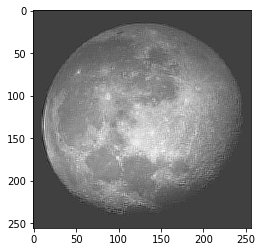

In [9]:
plt.imshow(f_r, cmap='gray')